## Изменение цены задания в Толоке пропорционально радиусу от центра города

In [204]:
#импорт библиотек
import pandas as pd
import numpy as np
#работа с геоданными
import geopandas as gpd
from shapely.geometry import Point
#скачивание данных через api
import requests
#визуализация
import matplotlib.pyplot as plt
#подсчет формул
from math import radians, cos, sin, asin, sqrt 

In [205]:
#Расстояние между двумя точками по формуле
def distance(lat1 , lon1, lat2=m_lat, lon2 = m_lon): 
      
    # The math module contains a function named 
    # radians which converts from degrees to radians. 
    lon1 = radians(lon1) 
    lon2 = radians(lon2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlon = lon2 - lon1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  
    c = 2 * asin(sqrt(a))  
     
    # Radius of earth in kilometers. Use 3956 for miles 
    r = 6371
       
    # calculate the result 
    return(c * r) 

In [206]:
#Расстояние между двумя точками с помощью проекций
def calculateDistance(row, dest_geom, src_col='geometry', target_col='distance'):
    """
    Calculates the distance between a single Shapely Point geometry and a GeoDataFrame with Point geometries.

    Parameters
    ----------
    dest_geom : shapely.Point
        A single Shapely Point geometry to which the distances will be calculated to.
    src_col : str
        A name of the column that has the Shapely Point objects from where the distances will be calculated from.
    target_col : str
        A name of the target column where the result will be stored.
    """
    # Calculate the distances
    dist = row[src_col].distance(dest_geom)
    # Tranform into kilometers
    dist_km = dist/1000
    # Assign the distance to the original data
    row[target_col] = dist_km
    return row

### Визуализация границ Москвы

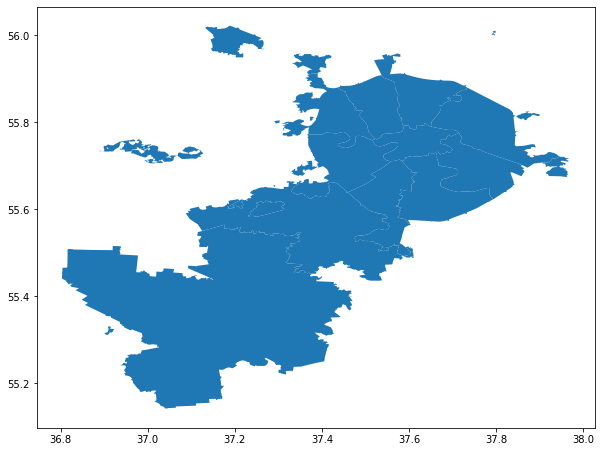

In [207]:
#скачиваем границы Москвы из gis-lab http://gis-lab.info/qa/moscow-atd.html
bound = gpd.read_file('ao.geojson', driver='GeoJSON')
bound.to_crs({"init": "epsg:4326"}, inplace = True)
bound.plot(figsize = (10,15))

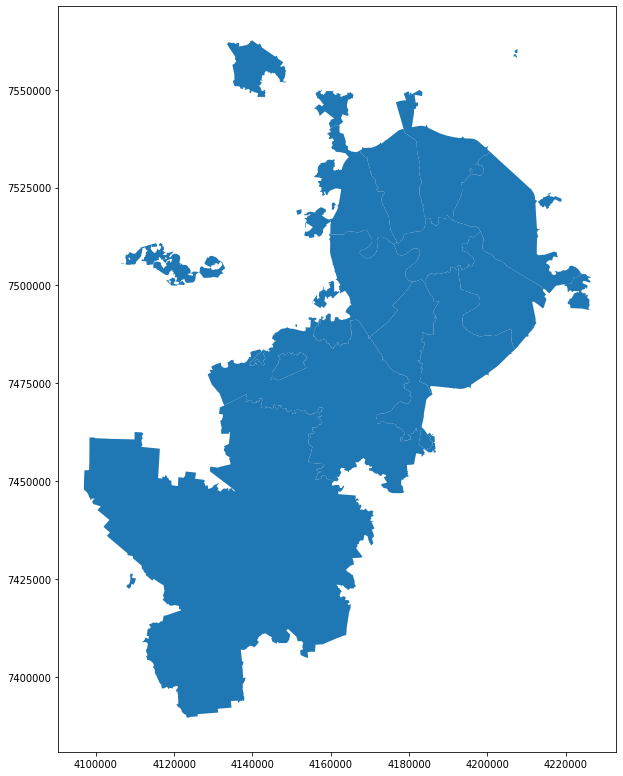

In [208]:
#Проекция меркатора
bound.to_crs({"init": "epsg:3857"}, ).plot(figsize = (10,15))

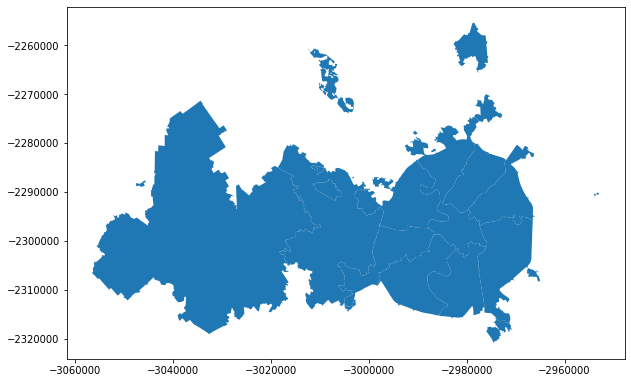

In [209]:
#Проекция Ламберта
bound.to_crs({"init": "epsg:3576"}, ).plot(figsize = (10,15))

### Скачиваем данные из Портала открытых данных г. Москвы

In [210]:
#api_key к данным . Подробнее на https://apidata.mos.ru/Docs#apiKeys
f = open('data_mos_ru_api.txt')
api_key_mos_ru = f.readline()

In [211]:
#скачиваем данные (данные взяты из https://data.mos.ru/opendata/7708308010-ledovye-polya-krytye)

#Крытые ледовые поля
id_dataset = '1232'
response = requests.get('https://apidata.mos.ru/v1/features/' + id_dataset + '?api_key=' + api_key_mos_ru + '&$top=100')

print(response)


<Response [200]>


In [212]:
dataset = gpd.read_file(response.content.decode(), driver='GeoJSON')
#Geographic projection, Latitude/Longitude - означает, что координаты даны в полярных угловых координатах
dataset.to_crs({"init": "epsg:4326"},inplace = True)
dataset.head()

,DatasetId,VersionNumber,ReleaseNumber,RowId,Attributes,geometry
0,1232,10,75,None,"{'global_id': 281852691, 'ObjectName': 'Крытое...",POINT (37.68988 55.74167)
1,1232,10,75,None,"{'global_id': 281852864, 'ObjectName': 'Крытое...",POINT (37.73629 55.73192)
2,1232,10,75,None,"{'global_id': 281853202, 'ObjectName': 'Крытое...",POINT (37.53442 55.88706)
3,1232,10,75,None,"{'global_id': 281853238, 'ObjectName': 'Дворец...",POINT (37.53960 55.78683)
4,1232,10,75,None,"{'global_id': 281853378, 'ObjectName': 'Крытое...",POINT (37.35159 55.64598)


In [213]:
# центр Москвы
m_lat = 55.7522
m_lon = 37.6156
df = pd.DataFrame({'City': ['Moscow'], 'Latitude': [55.7522], 'Longitude': [37.6156]})
mos_c = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs = {"init": "epsg:4326"})

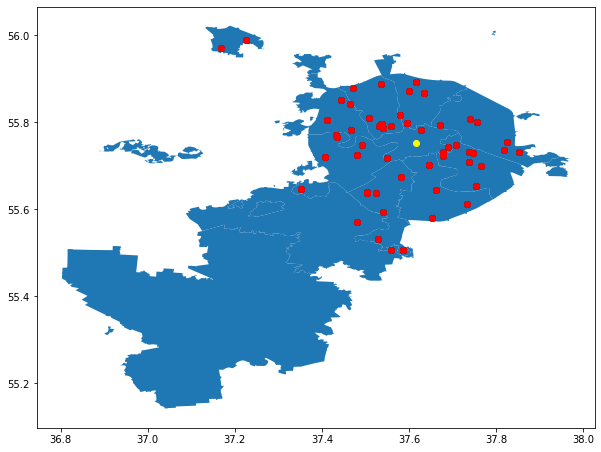

In [214]:
#Визуализация

fig, ax = plt.subplots(figsize = (10,30))
#Границы Москвы
bound.plot(ax = ax )
#Катки
dataset.plot(ax=ax, color="white", edgecolor="black")
dataset.plot(ax=ax, color="red",  figsize = (10,20))

#Центр Москвы
mos_c.plot(ax = ax , color = 'yellow')

### Расстояние по Яндекс картам между 1й точкой и центром москвы примеро 4,82к

In [216]:
projs = {'local' : "+proj= aeqd +lat_0 = 55.7522 +lon_0 = 37.6156"
    , 'world_geodetic' : "epsg:4326" , 'other' : 'epsg:3857'}

In [219]:
old_crs = dataset.crs
for name, proj in projs.items():
#переводим центр Москвы в нужную проекцию
    mos = mos_c.to_crs(proj)['geometry'][0]
#переводим все точки в нужную проекцию и считаем расстоние
    dataset = dataset.to_crs(proj).apply(lambda x :calculateDistance(x, mos, target_col = name), axis = 1)
    dataset.crs = proj
#возращаем исходую проекцию
dataset.to_crs(old_crs, inplace= True)

In [240]:
#Считаем по формуле
dataset['formula'] = dataset.apply(lambda x :distance(lat1 = x['geometry'].y, lon1 = x['geometry'].x, lon2 = mos_c['geometry'].x[0], lat2 = mos_c['geometry'].y[0]), axis = 1)

In [220]:
dataset.head()

,DatasetId,VersionNumber,ReleaseNumber,RowId,Attributes,geometry,local,world_geodetic,other
0,1232,10,75,None,"{'global_id': 281852691, 'ObjectName': 'Крытое...",POINT (37.68988 55.74167),4.809846,0.000075,8.527051
1,1232,10,75,None,"{'global_id': 281852864, 'ObjectName': 'Крытое...",POINT (37.73629 55.73192),7.909239,0.000122,14.020673
2,1232,10,75,None,"{'global_id': 281853202, 'ObjectName': 'Крытое...",POINT (37.53442 55.88706),15.853895,0.000157,28.208863
3,1232,10,75,None,"{'global_id': 281853238, 'ObjectName': 'Дворец...",POINT (37.53960 55.78683),6.133754,0.000084,10.888197
4,1232,10,75,None,"{'global_id': 281853378, 'ObjectName': 'Крытое...",POINT (37.35159 55.64598),20.381896,0.000285,36.111026


## Визуализация результатов

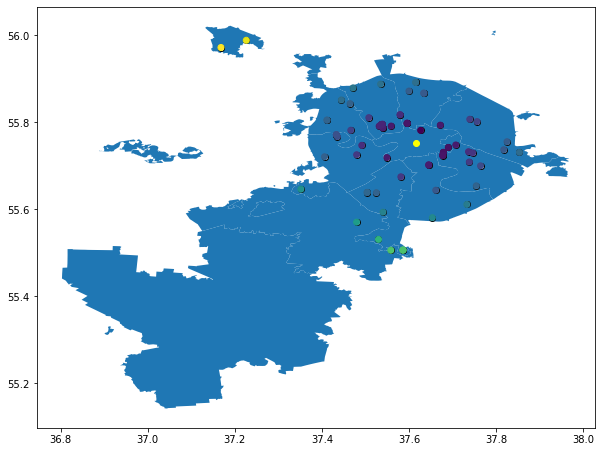

In [241]:
#Визуализация

fig, ax = plt.subplots(figsize = (10,30))
#Границы Москвы
bound.plot(ax = ax )
#Катки
dataset.plot(ax=ax, color="white", edgecolor="black")
dataset.plot(ax=ax, column = 'formula',  figsize = (10,20))
#Центр Москвы
mos_c.plot(ax = ax , color = 'yellow')

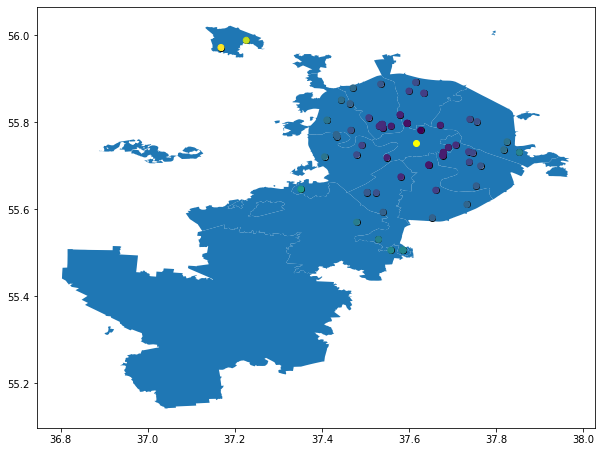

In [243]:
#Визуализация

fig, ax = plt.subplots(figsize = (10,30))
#Границы Москвы
bound.plot(ax = ax )
#Катки
dataset.plot(ax=ax, color="white", edgecolor="black")
dataset.plot(ax=ax, column = 'world_geodetic',  figsize = (10,20))
#Центр Москвы
mos_c.plot(ax = ax , color = 'yellow')

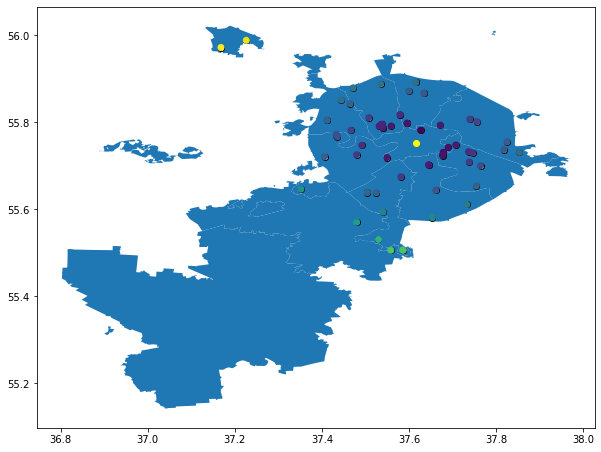

In [242]:
#Визуализация

fig, ax = plt.subplots(figsize = (10,30))
#Границы Москвы
bound.plot(ax = ax )
#Катки
dataset.plot(ax=ax, color="white", edgecolor="black")
dataset.plot(ax=ax, column = 'local',  figsize = (10,20))
#Центр Москвы
mos_c.plot(ax = ax , color = 'yellow')

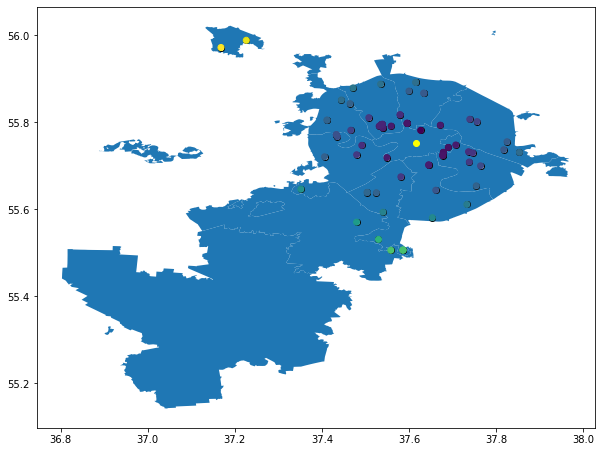

In [244]:
#Визуализация

fig, ax = plt.subplots(figsize = (10,30))
#Границы Москвы
bound.plot(ax = ax )
#Катки
dataset.plot(ax=ax, color="white", edgecolor="black")
dataset.plot(ax=ax, column = 'other',  figsize = (10,20))
#Центр Москвы
mos_c.plot(ax = ax , color = 'yellow')